For writing the narrative and exporting data.

In [52]:
import pickle
import math
import json
import numpy as np
import matplotlib.pyplot as plt

CUNAME = 'Columbia University in the City of New York'

S_TOTALS = pickle.load(open('../data/S_Sex_Graduates.p', 'rb'))
E_TOTALS = pickle.load(open('../data/E_Sex_Graduates.p', 'rb'))
D_TOTALS = pickle.load(open('../data/SE-Detailed_Sex.p', 'rb'))

years = sorted(S_TOTALS.keys())
institutions = sorted(S_TOTALS[ max(years) ].keys())
fields = {
    'Science': set(),
    'Engineering': set()
}
for year in years:
    inst_stats = D_TOTALS[year]['Columbia University in the City of New York']
    for seh in inst_stats.keys():
        for field in inst_stats[seh].keys():
            fields[seh].add(field)
fields['Science'] = sorted(fields['Science'])
fields['Engineering'] = sorted(fields['Engineering'])

print(f'{len(institutions)} institutions and {len(fields["Science"]) + len(fields["Engineering"])} fields.')

11 institutions and 39 fields.


In [53]:
# Returns female and male headcounts for a field in an institution
def get_counts(seh, field, inst='Columbia University in the City of New York', default=None):
    females = []
    males = []
    for year in years:
        stats = D_TOTALS[year][inst][seh].get(field, None)
        if stats is None:
            females.append(default)
            males.append(default)
            continue
        females.append(stats.get('Female', 0))
        males.append(stats.get('Male', 0))
    return females, males


complete_fields = {
    'Science': [],
    'Engineering': [],
}
for topic in complete_fields.keys():
    for field in fields[topic]:
        f, m = get_counts(topic, field)
        if None not in f and None not in m:
            complete_fields[topic].append(field)

print(f'{len(complete_fields["Science"]) + len(complete_fields["Engineering"])} complete fields.')

19 complete fields.


In [98]:
# Convenient function for making subplots
def subplots(num=1, cols=2, figsize=6):
    if num < cols:
        cols = num
    rows = math.ceil(num / cols)
    return plt.subplots(rows, cols, figsize=(figsize * cols, figsize * rows))

# Returns female and male headcounts for a field in an institution
def get_counts(field, inst='Columbia University in the City of New York', default=None):
    females = []
    males = []
    if field in complete_fields['Science']:
        topic = 'Science'
    elif field in complete_fields['Engineering']: 
        topic = 'Engineering'
    else:
        print(f'Field {field} not found.')
        return
    for year in years:
        stats = D_TOTALS[year][inst][topic].get(field, None)
        if stats is None:
            females.append(default)
            males.append(default)
            continue
        females.append(stats.get('Female', 0))
        males.append(stats.get('Male', 0))
    return females, males

def plot_proportions(ax, field, inst='Columbia University in the City of New York', title=None):
    females, males = get_counts(field, inst)
    proportions = []
    for i in range(len(years)):
        f, m = females[i], males[i]
        if f is None or m is None: 
            proportions.append(None)
        else:
            proportions.append(f / (m+f))
    ax.plot(years, proportions)
    ax.set_ylim(bottom=0, top=1)
    ax.set_title(title or field)

# Plots a female and male headcounts for a field
def plot_counts(ax, field, inst='Columbia University in the City of New York', title=None):
    females, males = get_counts(field, inst)
    ax.plot(years, females, label='Female')
    ax.plot(years, males, label='Male')
    ax.legend()
    ax.set_ylim(bottom=0)
    ax.set_title(title or field)
    ax.set_ylabel('Number of people')

def plot_connected(ax, field, inst='Columbia University in the City of New York', title=None):
    f, m = get_counts(field, inst, default=0)
    ax.plot(f, m, color='lightgray')
    ax.scatter(f, m, c=[i for i in range(len(m))], cmap='viridis')
    for i in [0, -1]:
        ax.annotate(years[i], (f[i], m[i]))    
    _, ymax = ax.get_ylim()
    _, xmax = ax.get_xlim()
    top = max(ymax, xmax)    
    ax.set_ylim(bottom=0, top=top)
    ax.set_xlim(left=0, right=top)    
    ax.set_title(title or field)
    ax.plot([0, top], [0, top], color='gray', linestyle='--')
    ax.set_xlabel('Number of women')
    ax.set_ylabel('Number of men')

def plot_triplet(ax_ary, index, field):
    plot_proportions(ax_ary[index, 0], field)
    plot_counts(ax_ary[index, 1], field)
    plot_connected(ax_ary[index, 2], field)

# Gets overall counts from complete fields for an institution in a topic
def get_overall_counts(topic, inst='Columbia University in the City of New York'):
    overallF = [0 for _ in range(len(years))]
    overallM = [0 for _ in range(len(years))]
    counts = {field: get_counts(field, inst, default=0) for field in complete_fields[topic]}

    for field in complete_fields[topic]:
        f, m = counts[field]
        for i in range(len(years)):
            overallF[i] += f[i]
            overallM[i] += m[i]
    return overallF, overallM

# Gets overall proportions from overall counts
def get_overall_proportions(topic, inst='Columbia University in the City of New York'):
    overallF, overallM = get_overall_counts(topic, inst)
    return [0 if m+f == 0 else f/(m+f) for f, m in zip(overallF, overallM)]

# Plots proportions for a topic
def plot_topic_proportions(ax, topic, peers=False, title=None):
    if peers:
        for inst in institutions:
            if inst != CUNAME:
                ax.plot(years, get_overall_proportions(topic, inst), color='lightblue', linewidth=1)
    ax.plot(years, get_overall_proportions(topic, CUNAME), color='blue', linewidth=2)
    ax.set_ylim(bottom=0, top=1)
    ax.set_title(title or topic)

# Plots a female and male headcounts for a topic
def plot_topic_counts(ax, topic, inst='Columbia University in the City of New York', title=None):
    females, males = get_overall_counts(topic, inst)
    ax.plot(years, females, label='Female')
    ax.plot(years, males, label='Male')
    ax.legend()
    ax.set_ylim(bottom=0)
    ax.set_title(title or topic)
    ax.set_ylabel('Number of people')

# Engineering

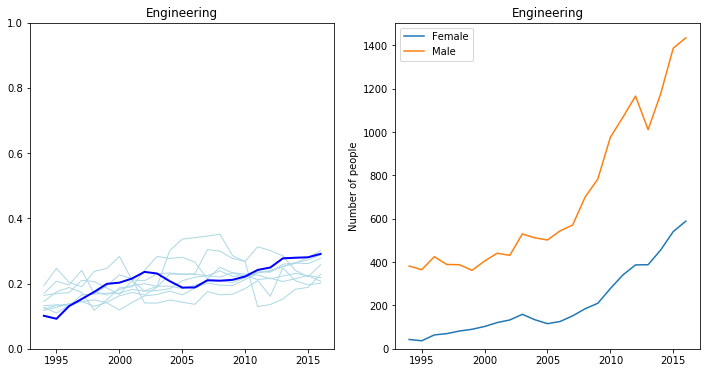

In [85]:
_, ax = subplots(2)
plot_topic_proportions(ax[0], 'Engineering', peers=True)
plot_topic_counts(ax[1], 'Engineering')

Rise after 2006 lies primarily in Industrial and Manufacturing Engineering, marginal help from Engineering Science, Mechanics, and Physics. Electrical Engineering and Mechanical Engineering were left behind.

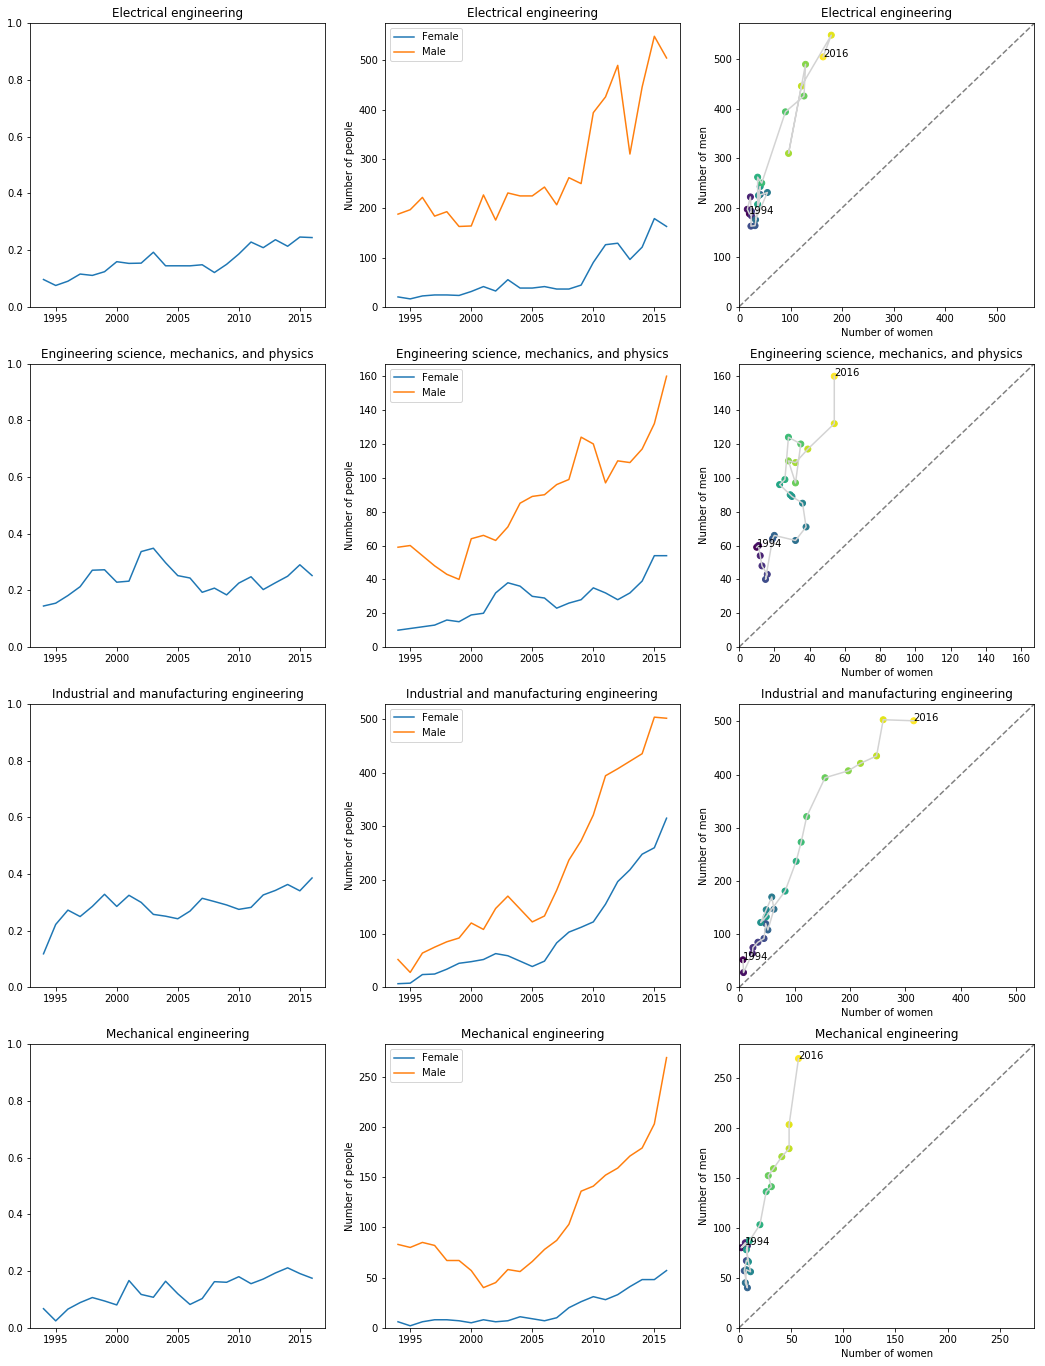

In [97]:
selected = complete_fields['Engineering']
_, ax = subplots(len(selected) * 3, cols=3)
for i, field in enumerate(selected):
    plot_triplet(ax, i, field)